## Erstellung eines 3D-Modells

Als Beispiel dient uns die [Brecherspitz](https://de.wikipedia.org/wiki/Brecherspitz) in den bayerischen Voralpen, weil sie eine interessante Form hat und der Gipfel gut in der entsprechenden km²-Kachel liegt.

![Brecherspitz](images/Blick_zur_Brecherspitz_(9965593375).jpg)  
Bildquelle: [Andrea Schieber from München, Deutschland](https://commons.wikimedia.org/wiki/File:Blick_zur_Brecherspitz_(9965593375).jpg), [BY-SA 2.0 CC](https://creativecommons.org/licenses/by-sa/2.0), via Wikimedia Commons


### Download der erforderlichen Ausgangsdaten
Für das 3D-Modell benötigen wir ein digitales Geländemodell und ein digitales Orthophoto. Beides ist auf dem [OpenData-Portal](https://geodaten.bayern.de/opengeodata/) der Bayerischen Vermessungsverwaltung verfügbar.

Unter Linux können die Dateien beispielsweise mit `wget` herunterladen werden.


In [1]:
%%bash
wget -nv -c https://download1.bayernwolke.de/a/dgm/dgm1/715_5284.tif
wget -nv -c https://download1.bayernwolke.de/a/dop40/data/32715_5284.tif

### Einlesen des digitalen Geländemodells

Für die weitere Verarbeitung wird das digitale Geländemodell (DGM) als `numpy`-2D-Array benötigt. Die Konvertierung erledigt `rasterio` für uns.

In [2]:
import rasterio
with rasterio.open("715_5284.tif") as src:
    points = src.read(1)

Das DGM hat eine Maschenweite von 1 m. Bei einer abgedeckten Fläche von 1 km² entspricht das 1 Mio Punkten.

Die folgende Abbildung zeigt das eingelesene DGM.

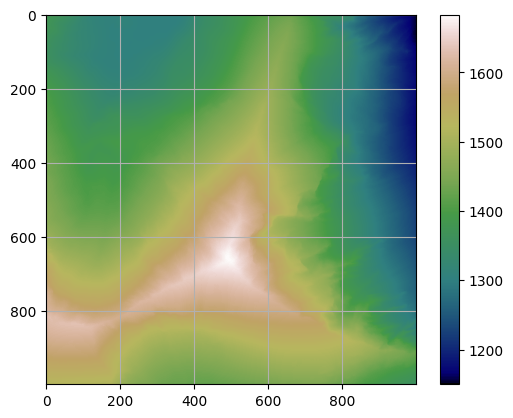

In [3]:
import matplotlib.pyplot as plt
im = plt.imshow(points, cmap='gist_earth')
plt.grid()
plt.colorbar(im)
plt.show()

### Erstellung eines TIN

Für die 3D-Darstellung muss die Anzahl der Punkte reduziert werden. Die verbleibenden Punkte werden dann dreiecksvermascht. Das Resultat wird als [TIN](https://de.wikipedia.org/wiki/Unregelm%C3%A4%C3%9Figes_Dreiecksnetz) (engl: Triangulated Irregular Network, dt: Unregelmäßiges Dreiecksnetz) bezeichnet.

Die Erzeugung des TIN übernimmt hier [`pydelatin`](https://github.com/kylebarron/pydelatin). Diese Python-Library setzt auf [`hmm`](https://github.com/fogleman/hmm) (heightmap meshing utility) auf. Dabei kommt der 1995 von Garland und Heckbert in [Fast Polygonal Approximation of Terrains and Height Fields](http://mgarland.org/files/papers/scape.pdf) beschriebene Algorithmus zur Anwendung, der sich dadurch auszeichnet, dass die geländeprägenden Punkte gefunden und verwendet werden.

In [4]:
from pydelatin import Delatin
tin = Delatin(points, max_points=10000, max_error=0.30)

Das so berechnete TIN wird anschließend in `pyvista` eingelesen.

Um das digitale Orthophoto (DOP) als Textur über das 3D-Modell legen zu können werden Textur-Koordinaten benötigt, die mit `texture_map_to_plane` berechnet werden können.

Ausserdem ist jetzt schon eine Vorschau auf das 3D-Modell möglich.

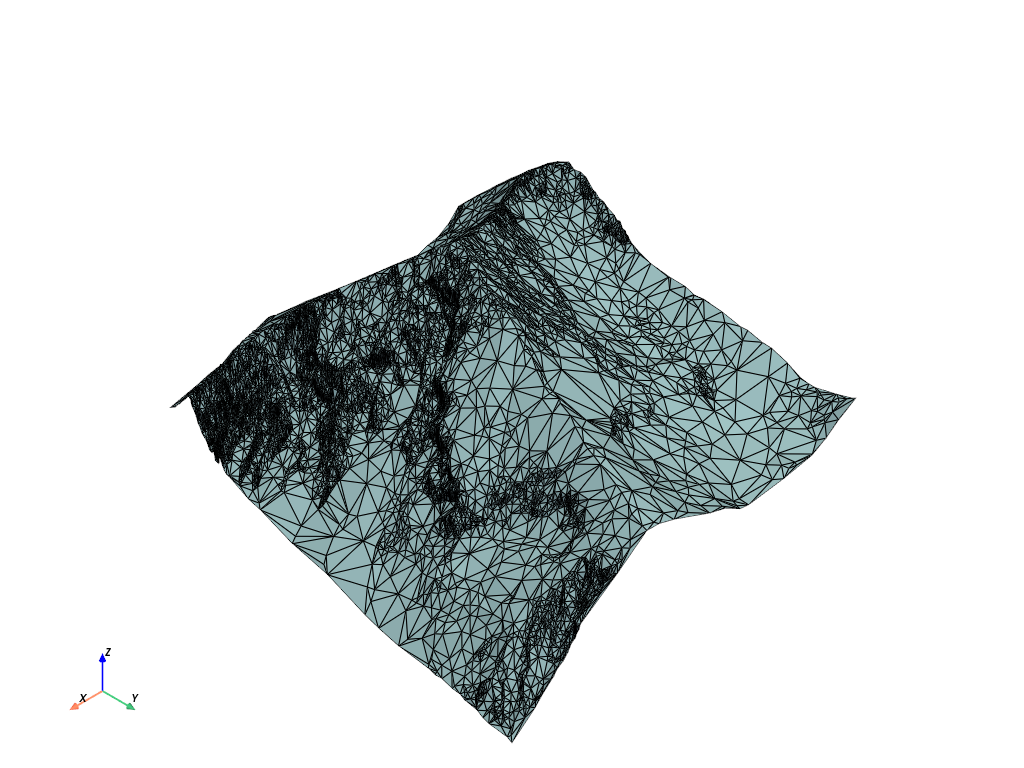

In [5]:
import pyvista as pv

vertices, triangles = tin.vertices, tin.triangles
polydata = pv.PolyData.from_regular_faces(vertices, triangles)

polydata.texture_map_to_plane(use_bounds=True, inplace=True)
texture_coordinates = polydata["Texture Coordinates"]
polydata.plot(show_edges=True, jupyter_backend='static')

Die Texturkoordinaten müssen jetzt noch für Open3D aufbereitet werden.

In [6]:
import numpy as np
uv_coords = []
for tri in triangles:
    for i in tri:
        uv_coords.append([texture_coordinates[i][0], texture_coordinates[i][1]])
v_uv = np.asarray(uv_coords, dtype=np.float64)

Um das Orthophoto als Textur verwenden zu können muss es in das PNG-Format konvertiert werden. Das erledigt `convert` für uns.
Die Fehlermeldungen können wir ignorieren.

In [7]:
%%bash
convert 32715_5284.tif 32715_5284.png

convert-im6.q16: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.
convert-im6.q16: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.
convert-im6.q16: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.
convert-im6.q16: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.
convert-im6.q16: Unknown field with tag 42112 (0xa480) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.


Mit der png-Datei ist jetzt auch eine texturierte Ansicht möglich.

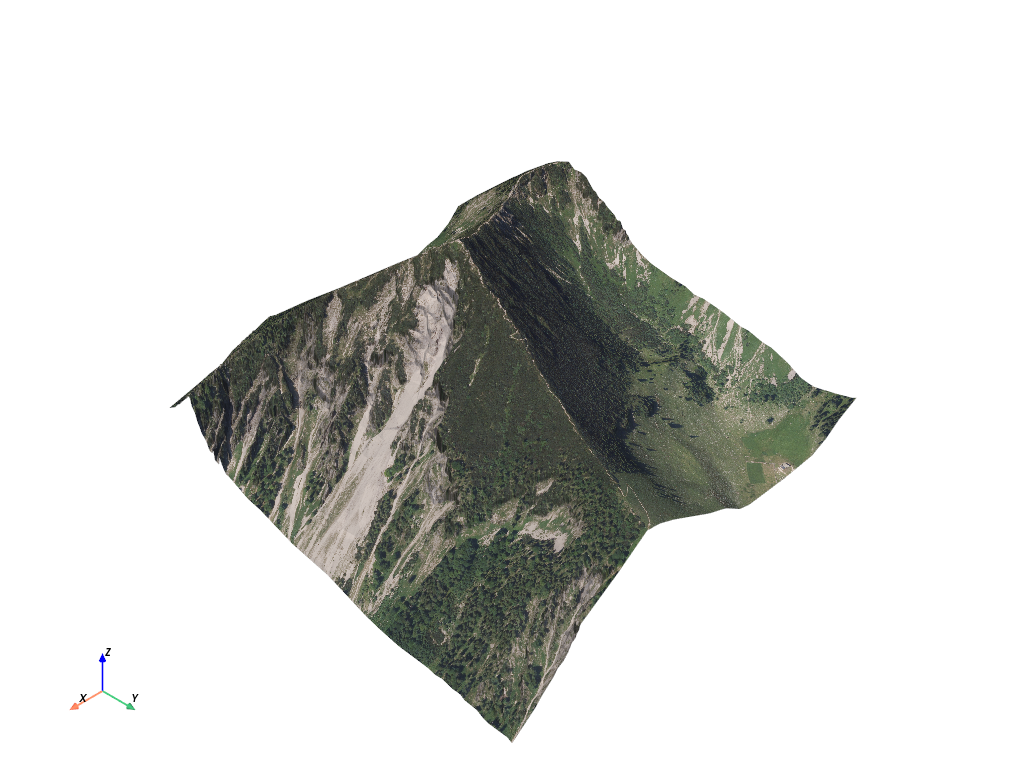

In [8]:
tex = pv.read_texture("32715_5284.png")
polydata.plot(texture=tex, jupyter_backend='static')

### Ausgabe des 3D-Modells als Wavefront OBJ-Datei

Leider kann `pyvista` keine texturierten 3D-Modelle als obj speichert. Deshalb kommt hier `open3d` zum Einsatz.

`open3d` benötigt das Texturbild gedreht, das machen wir hier mit OpenCV (`cv2`).


In [9]:
import cv2
path_to_image = "32715_5284.png"
img = cv2.imread(path_to_image)
flipped = cv2.flip(img, 0)

In [10]:
import open3d as o3d
mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vertices), o3d.utility.Vector3iVector(triangles))
mesh.textures = [o3d.geometry.Image(flipped)]
mesh.triangle_uvs = o3d.utility.Vector2dVector(v_uv)
mesh.triangle_material_ids = o3d.utility.IntVector([0] * len(triangles))
o3d.io.write_triangle_mesh("715_5284.obj", mesh)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


True

Das war´s ...

![GigaMesh](images/gigamesh.png)  
Screenshot von [GigaMesh](https://gigamesh.eu/) mit dem geladenen obj-File.